# Imports and Custom Functions

In [165]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from scipy import stats

In [173]:
def remove_zeros_distribution(X):

    return [i for i in X if i != 0]

def log_binning_distribution(x_i,B = 20): 
    
    x_i = remove_zeros_distribution(x_i)

    b_1 = min(x_i)
    b_Bp1 = max(x_i)
    q_1 = np.log(b_1)
    q_Bp1 = np.log(b_Bp1)
    D_q = q_Bp1 - q_1
    L_q = D_q / B

    q_list = []
    b_list = []

    for i in range(B):
        j = i + 1
        q_list.append(q_1 + (j-1)*L_q)
        b_list.append(np.exp(q_1 + (j-1)*L_q))

    # b_list.insert(0,b_1)
    # b_list.append(b_Bp1)
    
    binned_x_i = []
    density_list = []

    for i in range(len(b_list)-1):
        bin_low = b_list[i]
        bin_high = b_list[i+1]
        count_bin = 0
        for j in range(len(x_i)):
            if x_i[j] >= bin_low and x_i[j] < bin_high:
                count_bin = count_bin + 1
                
        if count_bin > 0:
            density_bin = count_bin / (len(x_i)*(bin_high-bin_low))
            density_list.append(density_bin)
            binned_x_i.append(bin_low)
        else:
            continue 
            
    return binned_x_i, density_list

# Randomizing

In [3]:
train = pd.read_csv('../data/Transformer_CNN_train_fold2.csv')
val = pd.read_csv('../data/Transformer_CNN_val_fold2.csv')
test = pd.read_csv('../data/Transformer_CNN_test_fold2.csv')

In [4]:
all_data = pd.concat([train,val,test])

In [27]:
positive_edge_count = len(all_data[all_data['Label'] == 1])
negative_edge_count = len(all_data[all_data['Label'] == 0])

print('Positive edge count: ', positive_edge_count)
print('Negative edge count: ', negative_edge_count)

Positive edge count:  11428
Negative edge count:  59322


In [34]:
ligands = list(set(all_data['SMILES'].tolist()))
targets = list(set(all_data['Target Sequence'].tolist()))

print('Distinct ligands: ', len(ligands))
print('Distinct targets: ', len(targets))

Distinct ligands:  13392
Distinct targets:  1507


In [7]:
# edge_list_layer = list(zip(all_data['InChiKey'],all_data['target_aa_code']))
edge_list_layer = list(zip(all_data['SMILES'],all_data['Target Sequence']))
edges_layer = len(edge_list_layer)

In [8]:
B = nx.Graph()
B.add_edges_from(edge_list_layer)

In [9]:
bipartite.is_bipartite(B)

True

In [10]:
edges_layer

70750

In [11]:
p_connection_layer = edges_layer / (len(ligands)*len(targets))

In [12]:
p_connection_layer

0.0035056435162392307

In [79]:
layers_randomized = nx.Graph(bipartite.random_graph(len(ligands), len(targets), p_connection_layer))

In [81]:
bipartite.is_bipartite(layers_randomized)

True

In [80]:
layers_randomized.number_of_edges()

70717

In [82]:
top_nodes = {n for n, d in layers_randomized.nodes(data=True) if d["bipartite"] == 0}

In [83]:
len(top_nodes) # These are the ligands

13392

In [84]:
bottom_nodes = set(layers_randomized) - top_nodes

In [85]:
len(bottom_nodes) # These are the targets

1507

In [86]:
randomized_ligand_degrees = []

for node_lig in top_nodes:
    randomized_ligand_degrees.append(layers_randomized.degree(node_lig))

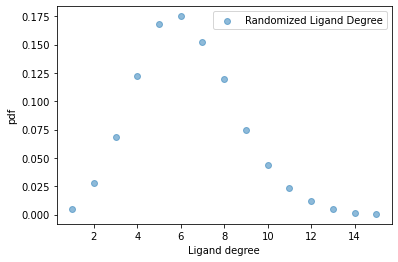

In [87]:
count, bins_count = np.histogram(randomized_ligand_degrees,bins=15)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.scatter(bins_count[1:],pdf, label="Randomized Ligand Degree",alpha=0.5)

plt.legend()
plt.xlabel('Ligand degree')
plt.ylabel('pdf')
plt.show()

In [88]:
randomized_target_degrees = []

for node_tar in bottom_nodes:
    randomized_target_degrees.append(layers_randomized.degree(node_tar))

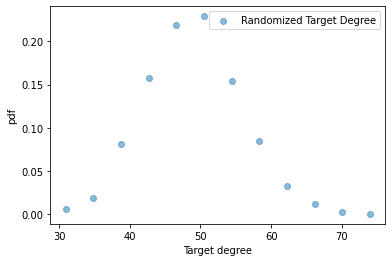

In [89]:
count, bins_count = np.histogram(randomized_target_degrees,bins=12)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.scatter(bins_count[1:],pdf, label="Randomized Target Degree",alpha=0.5)

plt.legend()
plt.xlabel('Target degree')
plt.ylabel('pdf')
plt.show()

# Creating DataFrame

In [101]:
randomized_samples = pd.DataFrame()

SMILE_list = []
target_aa_code_list = []

desired_positive_edge = int(len(list(layers_randomized.edges())) * positive_edge_count/(positive_edge_count + negative_edge_count))
desired_negative_edge = len(list(layers_randomized.edges())) - desired_positive_edge

for edge in list(layers_randomized.edges()):
    SMILE_list.append(ligands[edge[0]])
    target_aa_code_list.append(targets[edge[1]-len(ligands)]) ## bottom nodes indexing starts from len(ligands)
        
randomized_samples['SMILE'] = SMILE_list
randomized_samples['target_aa_code'] = target_aa_code_list
randomized_samples = randomized_samples.sample(frac=1).reset_index(drop=True)
randomized_samples['Y'] = [1] * desired_positive_edge + [0] * desired_negative_edge

In [102]:
len(randomized_samples[randomized_samples['Y'] == 1]) ## 11428

11422

In [103]:
len(randomized_samples[randomized_samples['Y'] == 0]) ## 59322

59295

In [104]:
ligand_pos_degree_randomized = []
ligand_degree_ratio_randomized = []

for chem in tqdm(set(randomized_samples['SMILE'].tolist())):
    sub_df = randomized_samples[randomized_samples['SMILE'] == chem]
    ligand_pos_degree_randomized.append(sub_df['Y'].tolist().count(1))
    ligand_degree_ratio_randomized.append(sub_df['Y'].tolist().count(1)/(sub_df['Y'].tolist().count(1)+sub_df['Y'].tolist().count(0)))

100%|██████████| 13327/13327 [01:50<00:00, 120.63it/s]


(array([5.585e+03, 4.965e+03, 0.000e+00, 2.056e+03, 0.000e+00, 5.680e+02,
        1.280e+02, 0.000e+00, 2.100e+01, 4.000e+00]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

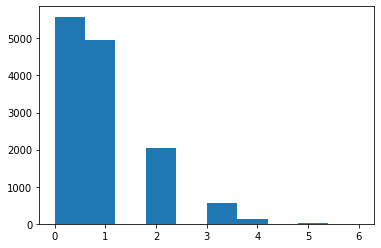

In [105]:
plt.hist(ligand_pos_degree_randomized)

In [106]:
target_pos_degree_randomized = []
target_degree_ratio_randomized = []

for prot in tqdm(set(randomized_samples['target_aa_code'].tolist())):
    sub_df = randomized_samples[randomized_samples['target_aa_code'] == prot]
    target_pos_degree_randomized.append(sub_df['Y'].tolist().count(1))
    target_degree_ratio_randomized.append(sub_df['Y'].tolist().count(1)/(sub_df['Y'].tolist().count(1)+sub_df['Y'].tolist().count(0)))

100%|██████████| 1507/1507 [00:12<00:00, 120.65it/s]


(array([  5.,  91., 267., 409., 180., 317., 164.,  64.,   6.,   4.]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <a list of 10 Patch objects>)

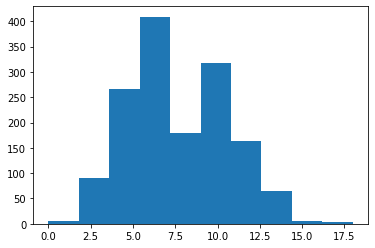

In [107]:
plt.hist(target_pos_degree_randomized)

# BindingDB Degree Ratios

In [185]:
ligand_pos_degree = []
ligand_neg_degree = []
ligand_annotations = []
ligand_degree_ratio_bindingDB = []

for chem in tqdm(set(all_data['SMILES'].tolist())):
    sub_df = all_data[all_data['SMILES'] == chem]
    ligand_pos_degree.append(sub_df['Label'].tolist().count(1))
    ligand_neg_degree.append(sub_df['Label'].tolist().count(0))
    ligand_annotations.append(len(sub_df))
    ligand_degree_ratio_bindingDB.append(sub_df['Label'].tolist().count(1)/(sub_df['Label'].tolist().count(1)+sub_df['Label'].tolist().count(0)))

100%|██████████| 13392/13392 [01:52<00:00, 119.30it/s]


In [187]:
binned_deg_ann, binned_ki_ann = log_binning_distribution(ligand_annotations,B = 20)
binned_deg_pos, binned_ki_pos = log_binning_distribution(ligand_pos_degree,B = 20)
binned_deg_neg, binned_ki_neg = log_binning_distribution(ligand_neg_degree,B = 20)

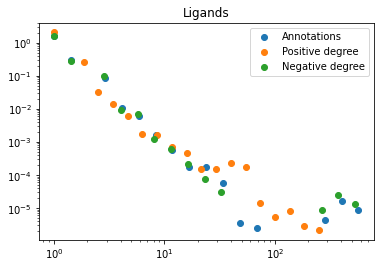

In [194]:
plt.scatter(binned_deg_ann, binned_ki_ann, label='Annotations')
plt.scatter(binned_deg_pos, binned_ki_pos, label='Positive degree')
plt.scatter(binned_deg_neg, binned_ki_neg, label='Negative degree')
plt.xscale('log')
plt.yscale('log')
plt.title('Ligands')
plt.legend()

In [190]:
stats.spearmanr(ligand_pos_degree, ligand_annotations)

SpearmanrResult(correlation=0.19228830229942806, pvalue=1.0182463611750579e-111)

In [191]:
stats.spearmanr(ligand_neg_degree, ligand_annotations)

SpearmanrResult(correlation=0.5837365393100225, pvalue=0.0)

In [192]:
stats.spearmanr(ligand_pos_degree, ligand_neg_degree)

SpearmanrResult(correlation=-0.5965683639069678, pvalue=0.0)

In [195]:
target_annotations = []
target_pos_degree = []
target_neg_degree = []
target_degree_ratio_bindingDB = []

for prot in tqdm(set(all_data['Target Sequence'].tolist())):
    sub_df = all_data[all_data['Target Sequence'] == prot]
    target_pos_degree.append(sub_df['Label'].tolist().count(1))
    target_neg_degree.append(sub_df['Label'].tolist().count(0))
    target_annotations.append(len(sub_df))
    target_degree_ratio_bindingDB.append(sub_df['Label'].tolist().count(1)/(sub_df['Label'].tolist().count(1)+sub_df['Label'].tolist().count(0)))

100%|██████████| 1507/1507 [00:12<00:00, 118.27it/s]


In [196]:
binned_deg_ann, binned_ki_ann = log_binning_distribution(target_annotations,B = 20)
binned_deg_pos, binned_ki_pos = log_binning_distribution(target_pos_degree,B = 20)
binned_deg_neg, binned_ki_neg = log_binning_distribution(target_neg_degree,B = 20)

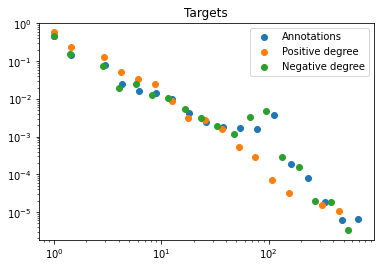

In [197]:
plt.scatter(binned_deg_ann, binned_ki_ann, label='Annotations')
plt.scatter(binned_deg_pos, binned_ki_pos, label='Positive degree')
plt.scatter(binned_deg_neg, binned_ki_neg, label='Negative degree')
plt.xscale('log')
plt.yscale('log')
plt.title('Targets')
plt.legend()

# Analysis of BindingDB Thresholding

In [198]:
df = pd.read_csv('/home/sars-busters-consolidated/data/BindingDB_All.tsv', sep = '\t', error_bad_lines=False)

b'Skipping line 896772: expected 193 fields, saw 205\nSkipping line 896798: expected 193 fields, saw 205\n'
b'Skipping line 929491: expected 193 fields, saw 205\n'
b'Skipping line 952161: expected 193 fields, saw 265\n'
b'Skipping line 1355895: expected 193 fields, saw 241\n'
b'Skipping line 1469800: expected 193 fields, saw 241\nSkipping line 1469801: expected 193 fields, saw 241\nSkipping line 1469802: expected 193 fields, saw 241\nSkipping line 1469803: expected 193 fields, saw 241\nSkipping line 1469804: expected 193 fields, saw 241\nSkipping line 1469805: expected 193 fields, saw 241\nSkipping line 1469806: expected 193 fields, saw 241\nSkipping line 1469807: expected 193 fields, saw 241\nSkipping line 1469808: expected 193 fields, saw 241\n'
b'Skipping line 1483073: expected 193 fields, saw 205\n'
b'Skipping line 1502296: expected 193 fields, saw 241\nSkipping line 1502297: expected 193 fields, saw 241\nSkipping line 1502298: expected 193 fields, saw 241\nSkipping line 1502299: e

In [199]:
df = df[df['Number of Protein Chains in Target (>1 implies a multichain complex)'] == 1.0]
df = df[df['Ligand SMILES'].notnull()]

idx_str = 'Kd (nM)'

df_want = df[df[idx_str].notnull()]
df_want = df_want[['BindingDB Reactant_set_id', 'Ligand InChI', 'Ligand SMILES',\
                    'PubChem CID', 'UniProt (SwissProt) Primary ID of Target Chain',\
                    'BindingDB Target Chain  Sequence', idx_str]]

df_want.rename(columns={'BindingDB Reactant_set_id':'ID', 'Ligand SMILES':'SMILES',\
                        'Ligand InChI':'InChI', 'PubChem CID':'PubChem_ID',
                        'UniProt (SwissProt) Primary ID of Target Chain':'UniProt_ID',
                        'BindingDB Target Chain  Sequence': 'Target Sequence',
                            idx_str: 'Label'}, inplace=True)

In [200]:
df_want['Label'] = df_want['Label'].str.replace('>', '')
df_want['Label'] = df_want['Label'].str.replace('<', '')
df_want['Label'] = df_want['Label'].astype(float)

# have at least uniprot or pubchem ID
df_want = df_want[df_want.PubChem_ID.notnull() | df_want.UniProt_ID.notnull()]
df_want = df_want[df_want.InChI.notnull()]

df_want = df_want[df_want.Label <= 10000000.0]
print('There are ' + str(len(df_want)) + ' drug target pairs.')

There are 70750 drug target pairs.


In [209]:
kd_list = list(df_want.Label.values)

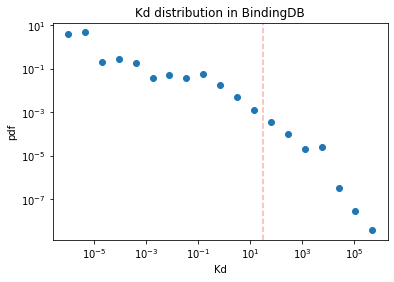

In [299]:
#plt.hist(kd_list, bins = 100)
binned_kd, binned_pdf = log_binning_distribution(kd_list,B = 20)
plt.scatter(binned_kd, binned_pdf)
plt.axvline(x = 30, linestyle='--', alpha=0.4, color='#e34a33')
plt.xscale('log')
plt.yscale('log')
plt.title('Kd distribution in BindingDB')
plt.xlabel('Kd')
plt.ylabel('pdf')
# plt.legend()
plt.show()

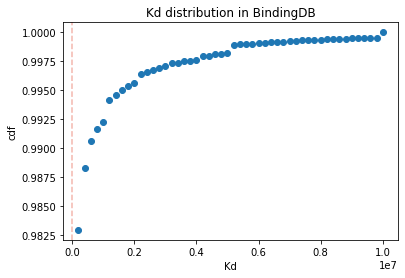

In [285]:
count, bins_count = np.histogram(kd_list, bins=50)
pdf = count / sum(count)
cdf = np.cumsum(pdf)

plt.scatter(bins_count[1:], cdf, marker='o')
plt.axvline(x = 30, linestyle='--', alpha=0.4, color='#e34a33')
plt.title('Kd distribution in BindingDB')
plt.xlabel('Kd')
plt.ylabel('cdf')
#plt.xscale('log')
#plt.yscale('log')
# plt.legend()
plt.show()

In [239]:
threshold = 30 ## in nM
kd_pos = []
kd_neg = []

for x in tqdm(kd_list):
    
    if x < threshold:
        kd_pos.append(x)
        
    if x >= threshold:
        kd_neg.append(x)


100%|██████████| 70750/70750 [00:00<00:00, 569597.14it/s]


In [240]:
print('Probability of observing binding annotation p: ', len(kd_pos)/len(kd_list))
print('Probability of observing non-binding annotation 1-p: ', len(kd_neg)/len(kd_list))

Probability of observing binding annotation p:  0.16152650176678446
Probability of observing non-binding annotation 1-p:  0.8384734982332156


# Reshuffling Kd

In [263]:
shuffled_kd = list(df_want.Label.values)
np.random.shuffle(shuffled_kd)

y = [1 if i < threshold else 0 for i in shuffled_kd]

Kd_shuffled_data = pd.DataFrame()

Kd_shuffled_data['SMILES'] = list(df_want.SMILES.values)
Kd_shuffled_data['Target Sequence'] = list(df_want['Target Sequence'].values)
Kd_shuffled_data['Label_Shuffled'] = y

In [264]:
Kd_shuffled_data

,SMILES,Target Sequence,Label_Shuffled
0,Cc1ccc(CNS(=O)(=O)c2ccc(s2)S(N)(=O)=O)cc1,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0
1,COc1ccc(CNS(=O)(=O)c2ccc(s2)S(N)(=O)=O)cc1,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,1
2,NS(=O)(=O)c1ccc(s1)S(=O)(=O)NCc1cccs1,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0
3,NS(=O)(=O)c1cc2C(O)CN(Cc3cccs3)S(=O)(=O)c2s1,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,1
4,COc1ccc(cc1)N1CC(O)c2cc(sc2S1(=O)=O)S(N)(=O)=O,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0
...,...,...,...
70745,CCCC(=O)c1ccc2Sc3ccccc3N(CCCN3CCN(C)CC3)c2c1,MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGEEHFKGL...,0
70746,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc23)CC1,MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGEEHFKGL...,0
70747,CN(C)CCCN1c2ccccc2Sc2ccc(cc12)C#N,MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGEEHFKGL...,1
70748,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(cc23)C(F)(F)F)CC1,MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGEEHFKGL...,0


## Ligands

In [265]:
ligand_pos_degree_shuffled = []
ligand_neg_degree_shuffled = []
ligand_annotations_shuffled = []
ligand_degree_ratio_bindingDB_shuffled = []

for chem in tqdm(set(Kd_shuffled_data['SMILES'].tolist())):
    sub_df = Kd_shuffled_data[Kd_shuffled_data['SMILES'] == chem]
    ligand_pos_degree_shuffled.append(sub_df['Label_Shuffled'].tolist().count(1))
    ligand_neg_degree_shuffled.append(sub_df['Label_Shuffled'].tolist().count(0))
    ligand_annotations_shuffled.append(len(sub_df))
    ligand_degree_ratio_bindingDB_shuffled.append(sub_df['Label_Shuffled'].tolist().count(1)/(sub_df['Label_Shuffled'].tolist().count(1)+sub_df['Label_Shuffled'].tolist().count(0)))

100%|██████████| 13392/13392 [01:52<00:00, 119.47it/s]


In [296]:
stats.spearmanr(ligand_annotations_shuffled, ligand_neg_degree_shuffled)

SpearmanrResult(correlation=0.8251966967089094, pvalue=0.0)

In [297]:
stats.spearmanr(ligand_pos_degree_shuffled, ligand_annotations_shuffled)

SpearmanrResult(correlation=0.32991408162620633, pvalue=0.0)

In [298]:
stats.spearmanr(ligand_pos_degree_shuffled, ligand_neg_degree_shuffled)

SpearmanrResult(correlation=-0.18021772069705663, pvalue=3.800885231178212e-98)

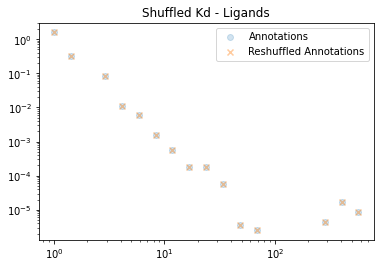

In [273]:
binned_deg_ann, binned_ki_ann = log_binning_distribution(ligand_annotations,B = 20)
#binned_deg_pos, binned_ki_pos = log_binning_distribution(ligand_pos_degree,B = 20)
#binned_deg_neg, binned_ki_neg = log_binning_distribution(ligand_neg_degree,B = 20)

plt.scatter(binned_deg_ann, binned_ki_ann, label='Annotations',alpha=0.2)
#plt.scatter(binned_deg_pos, binned_ki_pos, label='Positive degree')
#plt.scatter(binned_deg_neg, binned_ki_neg, label='Negative degree')

binned_deg_ann, binned_ki_ann = log_binning_distribution(ligand_annotations_shuffled,B = 20)
#binned_deg_pos, binned_ki_pos = log_binning_distribution(ligand_pos_degree_shuffled,B = 20)
#binned_deg_neg, binned_ki_neg = log_binning_distribution(ligand_neg_degree_shuffled,B = 20)

plt.scatter(binned_deg_ann, binned_ki_ann, label='Reshuffled Annotations', marker='x', alpha=0.4)
#plt.scatter(binned_deg_pos, binned_ki_pos, label='Reshuffled Positive degree')
#plt.scatter(binned_deg_neg, binned_ki_neg, label='Reshuffled Negative degree')
plt.xscale('log')
plt.yscale('log')
plt.title('Shuffled Kd - Ligands')
plt.legend()
plt.show()

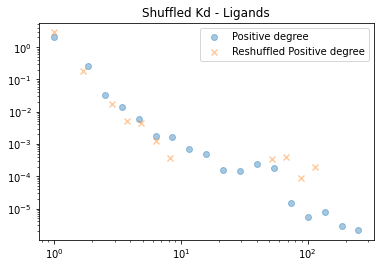

In [276]:
binned_deg_pos, binned_ki_pos = log_binning_distribution(ligand_pos_degree,B = 20)

plt.scatter(binned_deg_pos, binned_ki_pos, label='Positive degree',alpha=0.4)

binned_deg_pos, binned_ki_pos = log_binning_distribution(ligand_pos_degree_shuffled,B = 20)

plt.scatter(binned_deg_pos, binned_ki_pos, label='Reshuffled Positive degree',marker='x', alpha=0.4)

plt.xscale('log')
plt.yscale('log')
plt.title('Shuffled Kd - Ligands')
plt.legend()

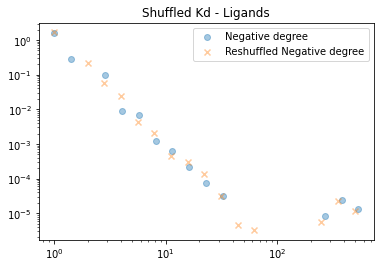

In [277]:
binned_deg_neg, binned_ki_neg = log_binning_distribution(ligand_neg_degree,B = 20)

plt.scatter(binned_deg_neg, binned_ki_neg, label='Negative degree',alpha=0.4)

binned_deg_neg, binned_ki_neg = log_binning_distribution(ligand_neg_degree_shuffled,B = 20)

plt.scatter(binned_deg_neg, binned_ki_neg, label='Reshuffled Negative degree',marker='x', alpha=0.4)

plt.xscale('log')
plt.yscale('log')
plt.title('Shuffled Kd - Ligands')
plt.legend()

## Degree Ratios with Reshuffling 

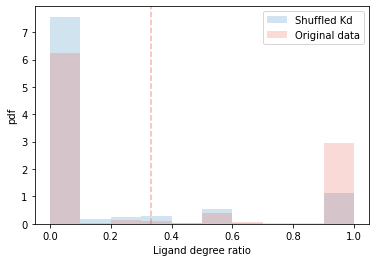

In [282]:
plt.hist(ligand_degree_ratio_bindingDB_shuffled,label='Shuffled Kd',alpha=0.2,density=True)
plt.hist(ligand_degree_ratio_bindingDB, label='Original data',alpha=0.2,density=True, color='#e34a33')
plt.axvline(x = np.mean(ligand_degree_ratio_bindingDB), linestyle='--', alpha=0.4, color='#e34a33')

plt.legend()
plt.xlabel('Ligand degree ratio')
plt.ylabel('pdf')
plt.show()

In [286]:
np.mean(ligand_degree_ratio_bindingDB_shuffled) ## This is equal to p

0.16141157427376587

In [288]:
np.mean(ligand_degree_ratio_bindingDB)

0.3331005361246504

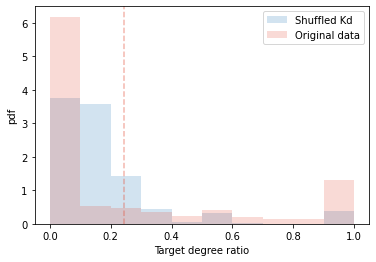

In [283]:
plt.hist(target_degree_ratio_bindingDB_shuffled,label='Shuffled Kd',alpha=0.2,density=True)
plt.hist(target_degree_ratio_bindingDB, label='Original data',alpha=0.2,density=True, color='#e34a33')
plt.axvline(x = np.mean(target_degree_ratio_bindingDB), linestyle='--', alpha=0.4, color='#e34a33')

plt.legend()
plt.xlabel('Target degree ratio')
plt.ylabel('pdf')
plt.show()

In [287]:
np.mean(target_degree_ratio_bindingDB_shuffled) ## This is equal to p

0.1652230394389105

In [289]:
np.mean(target_degree_ratio_bindingDB)

0.24216754819807698

## Targets

In [278]:
target_pos_degree_shuffled = []
target_neg_degree_shuffled = []
target_annotations_shuffled = []
target_degree_ratio_bindingDB_shuffled = []

for chem in tqdm(set(Kd_shuffled_data['Target Sequence'].tolist())):
    sub_df = Kd_shuffled_data[Kd_shuffled_data['Target Sequence'] == chem]
    target_pos_degree_shuffled.append(sub_df['Label_Shuffled'].tolist().count(1))
    target_neg_degree_shuffled.append(sub_df['Label_Shuffled'].tolist().count(0))
    target_annotations_shuffled.append(len(sub_df))
    target_degree_ratio_bindingDB_shuffled.append(sub_df['Label_Shuffled'].tolist().count(1)/(sub_df['Label_Shuffled'].tolist().count(1)+sub_df['Label_Shuffled'].tolist().count(0)))

100%|██████████| 1507/1507 [00:12<00:00, 119.56it/s]


In [293]:
stats.spearmanr(target_pos_degree_shuffled, target_annotations_shuffled)

SpearmanrResult(correlation=0.9128217963749675, pvalue=0.0)

In [294]:
stats.spearmanr(target_neg_degree_shuffled, target_annotations_shuffled)

SpearmanrResult(correlation=0.98999745479646, pvalue=0.0)

In [295]:
stats.spearmanr(target_pos_degree_shuffled, target_neg_degree_shuffled)

SpearmanrResult(correlation=0.8681214487637176, pvalue=0.0)

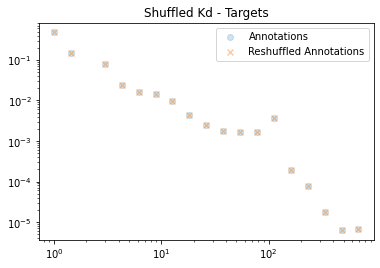

In [279]:
binned_deg_ann, binned_ki_ann = log_binning_distribution(target_annotations,B = 20)
#binned_deg_pos, binned_ki_pos = log_binning_distribution(target_pos_degree,B = 20)
#binned_deg_neg, binned_ki_neg = log_binning_distribution(target_neg_degree,B = 20)

plt.scatter(binned_deg_ann, binned_ki_ann, label='Annotations',alpha=0.2)
#plt.scatter(binned_deg_pos, binned_ki_pos, label='Positive degree')
#plt.scatter(binned_deg_neg, binned_ki_neg, label='Negative degree')

binned_deg_ann, binned_ki_ann = log_binning_distribution(target_annotations_shuffled,B = 20)
#binned_deg_pos, binned_ki_pos = log_binning_distribution(target_pos_degree_shuffled,B = 20)
#binned_deg_neg, binned_ki_neg = log_binning_distribution(target_neg_degree_shuffled,B = 20)

plt.scatter(binned_deg_ann, binned_ki_ann, label='Reshuffled Annotations', marker='x', alpha=0.4)
#plt.scatter(binned_deg_pos, binned_ki_pos, label='Reshuffled Positive degree')
#plt.scatter(binned_deg_neg, binned_ki_neg, label='Reshuffled Negative degree')
plt.xscale('log')
plt.yscale('log')
plt.title('Shuffled Kd - Targets')
plt.legend()
plt.show()

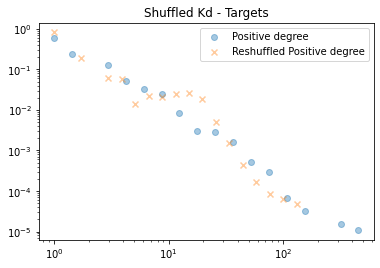

In [280]:
binned_deg_pos, binned_ki_pos = log_binning_distribution(target_pos_degree,B = 20)

plt.scatter(binned_deg_pos, binned_ki_pos, label='Positive degree',alpha=0.4)

binned_deg_pos, binned_ki_pos = log_binning_distribution(target_pos_degree_shuffled,B = 20)

plt.scatter(binned_deg_pos, binned_ki_pos, label='Reshuffled Positive degree',marker='x', alpha=0.4)

plt.xscale('log')
plt.yscale('log')
plt.title('Shuffled Kd - Targets')
plt.legend()

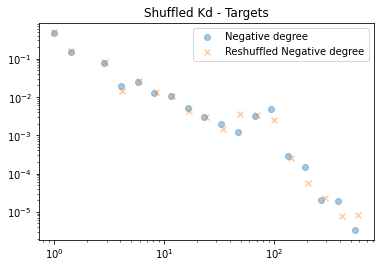

In [281]:
binned_deg_neg, binned_ki_neg = log_binning_distribution(target_neg_degree,B = 20)

plt.scatter(binned_deg_neg, binned_ki_neg, label='Negative degree',alpha=0.4)

binned_deg_neg, binned_ki_neg = log_binning_distribution(target_neg_degree_shuffled,B = 20)

plt.scatter(binned_deg_neg, binned_ki_neg, label='Reshuffled Negative degree',marker='x', alpha=0.4)

plt.xscale('log')
plt.yscale('log')
plt.title('Shuffled Kd - Targets')
plt.legend()

# Distribution of Degree Ratios

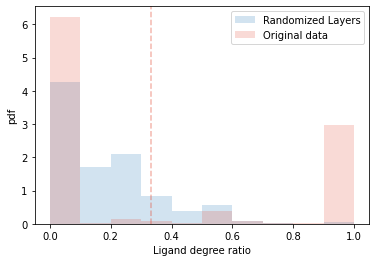

In [122]:
plt.hist(ligand_degree_ratio_randomized,label='Randomized Layers',alpha=0.2,density=True)
plt.hist(ligand_degree_ratio_bindingDB, label='Original data',alpha=0.2,density=True, color='#e34a33')
plt.axvline(x = np.mean(ligand_degree_ratio_bindingDB), linestyle='--', alpha=0.4, color='#e34a33')

plt.legend()
plt.xlabel('Ligand degree ratio')
plt.ylabel('pdf')
plt.show()

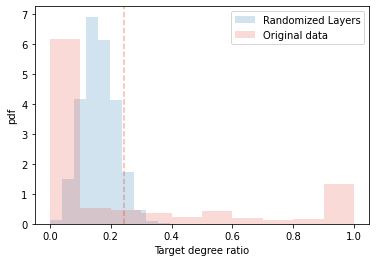

In [118]:
plt.hist(target_degree_ratio_randomized,label='Randomized Layers',alpha=0.2,density=True)
plt.hist(target_degree_ratio_bindingDB, label='Original data',alpha=0.2,density=True, color='#e34a33')
plt.axvline(x = np.mean(target_degree_ratio_bindingDB), linestyle='--', alpha=0.4, color='#e34a33')

plt.legend()
plt.xlabel('Target degree ratio')
plt.ylabel('pdf')
plt.show()

# Test for Poisson Distributions

In [148]:
x1_list = []
x2_list = []
rho_list = []

for i in tqdm(range(100000)):
    x1 = np.random.poisson(lam=0.5)
    x2 = np.random.poisson(lam=0.5)
    if x1 + x2 != 0:
        x1_list.append(x1)
        x2_list.append(x2)
        rho_list.append(x1/(x1+x2))

100%|██████████| 100000/100000 [00:00<00:00, 212006.46it/s]


Text(0, 0.5, 'pdf')

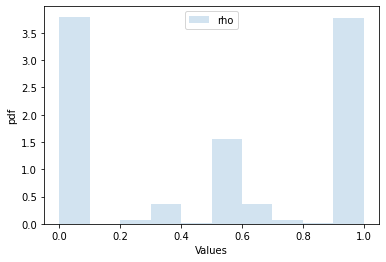

In [149]:
#plt.hist(x1_list,alpha=0.2,label='x1',density=True)
#plt.hist(x2_list,alpha=0.2,label='x2',density=True)
plt.hist(rho_list,alpha=0.2,label='rho',density=True)

plt.legend()
plt.xlabel('Values')
plt.ylabel('pdf')

In [137]:
x1_list = []
x2_list = []
rho_list = []

for i in tqdm(range(100000)):
    x1 = np.random.normal(loc=4, scale=1.0)
    x2 = np.random.normal(loc=5, scale=1.0)
    if x1 + x2 != 0:
        x1_list.append(x1)
        x2_list.append(x2)
        rho_list.append(x1/(x1+x2))

100%|██████████| 100000/100000 [00:01<00:00, 89814.48it/s]


Text(0, 0.5, 'pdf')

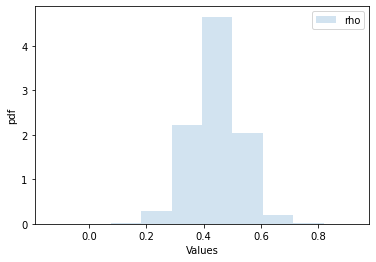

In [138]:
#plt.hist(x1_list,alpha=0.2,label='x1',density=True)
#plt.hist(x2_list,alpha=0.2,label='x2',density=True)
plt.hist(rho_list,alpha=0.2,label='rho',density=True)

plt.legend()
plt.xlabel('Values')
plt.ylabel('pdf')

In [140]:
x1_list = []
x2_list = []
rho_list = []

for i in tqdm(range(100000)):
    x1 = np.random.power(3.3)
    x2 = np.random.power(3.4)
    if x1 + x2 != 0:
        x1_list.append(x1)
        x2_list.append(x2)
        rho_list.append(x1/(x1+x2))

100%|██████████| 100000/100000 [00:00<00:00, 254867.07it/s]


Text(0, 0.5, 'pdf')

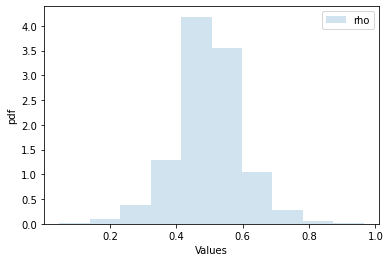

In [141]:
#plt.hist(x1_list,alpha=0.2,label='x1',density=True)
#plt.hist(x2_list,alpha=0.2,label='x2',density=True)
plt.hist(rho_list,alpha=0.2,label='rho',density=True)

plt.legend()
plt.xlabel('Values')
plt.ylabel('pdf')

# Duplex Configuration Model on Randomized Version

In [150]:
randomized_samples

,SMILE,target_aa_code,Y
0,CC[C@H](C)[C@H](NC(=O)[C@@H](N)CCC(N)=O)C(=O)N...,MPKRGKKGAVAEDGDELRTEPEAKKSKTAAKKNDKEAAGEGPALYE...,1
1,Fc1ccc(c(F)c1)S(=O)(=O)Nc1cncc(c1)-c1cnc2[nH]c...,MEMYETLGKVGEGSYGTVMKCKHKNTGQIVAIKIFYERPEQSVNKI...,1
2,CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](Cc1ccccc...,MGMACLTMTEMEGTSTSSIYQNGDISGNANSMKQIDPVLQVYLYHS...,1
3,CO[C@@]1(CN2CCC1CC2)C#C[C@@](O)(C1CCCCCCC1)c1c...,MSIEIPAGLTELLQGFTVEVLRHQPADLLEFALQHFTRLQQENERK...,1
4,CC1CC(CC(C)(C)C1)OCC(O)CNC(C)(C)C,MWNLLHETDSAVATARRPRWLCAGALVLAGGFFLLGFLFGWFIKSS...,1
...,...,...,...
70712,CCCN1CCN(CC1)c1nc2cnccc2o1,MESYHKPDQQKLQALKDTANRLRISSIQATTAAGSGHPTSCCSAAE...,0
70713,CC(C)[C@H](NC(=O)[C@@H](Cc1c[nH]c2ccccc12)NC(=...,MASESETLNPSARIMTFYPTMEEFRNFSRYIAYIESQGAHRAGLAK...,0
70714,CN(CCCNc1nc(Nc2ccc(OCCCOCCCCOCCCOCC(=O)N[C@H](...,MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...,0
70715,COc1cc2ccc3O[C@@H]([C@@H](N)Cc3c2cc1OC)c1cc(F)...,MWNLLHETDSAVATARRPRWLCAGALVLAGGFFLLGFLFGWFIKSS...,0


In [151]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(randomized_samples, test_size=0.3)

In [152]:
train

,SMILE,target_aa_code,Y
50192,Cc1cc(NC(=O)c2ccc(Br)cc2)[nH]n1,MALLRDVSLQDPRDRFELLQRVGAGTYGDVYKARDTVTSELAAVKI...,0
16982,CC(C)C[C@H](NC(=O)CCCCNC(=O)c1cc(ccc1-c1c2ccc(...,MAENKGGGEAESGGGGSGSAPVTAGAAGPAAQEAEPPLTAVLVEEE...,0
38430,CSc1nc(Cl)c(C=O)c(NCc2ccc(cc2)S(N)(=O)=O)n1,MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDL...,0
62503,CC(=C)CCNc1ncnc2n(cnc12)[C@@H]1O[C@H](CO)[C@@H...,MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKT...,0
15280,CC[C@H](C)[C@H](NC(=O)[C@@H](C[C@H](O)[C@H](CC...,MFQASMRSPNMEPFKQQKVEDFYDIGEELGSGQFAIVKKCREKSTG...,0
...,...,...,...
13767,CC(C)(C)C(=O)CN1c2ccccc2C(=NN(CC(=O)Nc2cccc(c2...,MEEEEGAVAKEWGTTPAGPVWTAVFDYEAAGDEELTLRRGDRVQVL...,0
434,Cc1c(C)c2OC(C)(CCc2c(C)c1O)C(=O)NCCO[N+]([O-])=O,HHHHHHHHMLARALLLCAVLALSHTANPCCSHPCQNRGVCMSVGFD...,1
40610,OC1CCN(Cc2cc(NC(=O)CN3CCCCC3)cc(Nc3ccnc4cc(Cl)...,MSGPVTFEKTFRRDALIDIEKKYQKVWAEEKVFEVDAPTFEECPIE...,0
508,C[C@H](O)CNc1cc(ccn1)-n1c(nc2ccccc12)-c1ccc2cc...,MKANLLVLLCALAAADADTICIGYHANNSTDTVDTVLEKNVTVTHS...,1


In [153]:
ligands = list(set(train['SMILE'].tolist()))
targets = list(set(train['target_aa_code'].tolist()))

number_ligands = len(ligands)
number_targets = len(targets)
print('Ligands: ', number_ligands)
print('Targets: ',number_targets)

Ligands:  13024
Targets:  1507


In [154]:
ligands_degree_dict = dict()

for smile_chem in tqdm(ligands):
    sum_df = train[train['SMILE'] == smile_chem]
    ligands_degree_dict[smile_chem] = dict()
    ligands_degree_dict[smile_chem]['deg_0'] = len(sum_df[sum_df['Y'] == 0])
    ligands_degree_dict[smile_chem]['deg_1'] = len(sum_df[sum_df['Y'] == 1])
    
targets_degree_dict = dict()

for aa_target in tqdm(targets):
    sum_df = train[train['target_aa_code'] == aa_target]
    targets_degree_dict[aa_target] = dict()
    targets_degree_dict[aa_target]['deg_0'] = len(sum_df[sum_df['Y'] == 0])
    targets_degree_dict[aa_target]['deg_1'] = len(sum_df[sum_df['Y'] == 1])
    
degree_train_1_0_ligands = [ligands_degree_dict[key_val]['deg_1'] for key_val in tqdm(ligands_degree_dict.keys())]
degree_train_0_1_ligands = [ligands_degree_dict[key_val]['deg_0'] for key_val in tqdm(ligands_degree_dict.keys())]

degree_train_1_0_targets = [targets_degree_dict[key_val]['deg_1'] for key_val in tqdm(targets_degree_dict.keys())]
degree_train_0_1_targets = [targets_degree_dict[key_val]['deg_0'] for key_val in tqdm(targets_degree_dict.keys())]

100%|██████████| 1507/1507 [00:00<00:00, 1242787.28it/s]


In [155]:
with open('../data/randomized_poisson/degreetrain10ligands.txt', 'w') as file:
    for degree in degree_train_1_0_ligands:
        file.write("%i\n" % degree)
        
file.close()

with open('../data/randomized_poisson/degreetrain01ligands.txt', 'w') as file:
    for degree in degree_train_0_1_ligands:
        file.write("%i\n" % degree)
        
file.close()

with open('../data/randomized_poisson/degreetrain10targets.txt', 'w') as file:
    for degree in degree_train_1_0_targets:
        file.write("%i\n" % degree)
        
file.close()

with open('../data/randomized_poisson/degreetrain01targets.txt', 'w') as file:
    for degree in degree_train_0_1_targets:
        file.write("%i\n" % degree)
        
file.close()

textfile = open("../data/randomized_poisson/ligands.txt", "w")
for element in ligands:
    textfile.write(element + "\n")
textfile.close()

textfile = open("../data/randomized_poisson/targets.txt", "w")
for element in targets:
    textfile.write(element + "\n")
textfile.close()

In [156]:
text_file = open("../data/randomized_poisson/ligands.txt", "r") # Rows of the adjacency matrix in order
ligands = text_file.readlines()

text_file = open("../data/randomized_poisson/targets.txt", "r") # Columns of the adjacency matrix in order 
targets = text_file.readlines()

In [157]:
summat10 = np.loadtxt(open("../data/randomized_poisson/summat10.csv", "rb"), delimiter=",", skiprows=0) # Output of MATLAB run
summat01 = np.loadtxt(open("../data/randomized_poisson/summat01.csv", "rb"), delimiter=",", skiprows=0) # Output of MATLAB run 

In [161]:
train_pos = train[train['Y'] == 1]
train_neg = train[train['Y'] == 0]

pos_deg_0_ligands = []
pos_deg_0_targets = []
neg_deg_0_ligands = []
neg_deg_0_targets = []

ligand_degree_ratio = dict()
ligand_all_average = []

for ligand in tqdm(ligands):
    pos_deg = len(train_pos[train_pos['SMILE'] == ligand])
    neg_deg = len(train_neg[train_neg['SMILE'] == ligand])
    if pos_deg + neg_deg != 0:
        ligand_degree_ratio[ligand] = dict()
        ligand_degree_ratio[ligand]['deg_ratio'] = pos_deg / (pos_deg + neg_deg)
        ligand_degree_ratio[ligand]['deg_avg'] = pos_deg / number_targets 
        ligand_all_average.append(pos_deg / number_targets)
    if pos_deg == 0:
        pos_deg_0_ligands.append(ligand)
    if neg_deg == 0:
        neg_deg_0_ligands.append(ligand)
    
ligands_all_avg = sum(ligand_all_average) / number_ligands

targets_degree_ratio = dict()
target_all_average = []

for target in tqdm(targets):
    pos_deg = len(train_pos[train_pos['target_aa_code'] == target])
    neg_deg = len(train_neg[train_neg['target_aa_code'] == target])
    if pos_deg + neg_deg != 0:
        targets_degree_ratio[target] = dict()
        targets_degree_ratio[target]['deg_ratio'] = pos_deg / (pos_deg + neg_deg)
        targets_degree_ratio[target]['deg_avg'] = pos_deg / number_ligands
        target_all_average.append(pos_deg / number_ligands)
    if pos_deg == 0:
        pos_deg_0_targets.append(target)
    if neg_deg == 0:
        neg_deg_0_targets.append(target)
    
targets_all_avg = sum(target_all_average) / number_targets

100%|██████████| 1507/1507 [00:09<00:00, 151.51it/s]


In [162]:
## Annotated means the node has at least 1 binding information

pos_annotated_ligands = list(set(ligands)-set(pos_deg_0_ligands))
pos_annotated_targets = list(set(targets)-set(pos_deg_0_targets))

neg_annotated_ligands = list(set(ligands)-set(neg_deg_0_ligands))
neg_annotated_targets = list(set(targets)-set(neg_deg_0_targets))

In [163]:
test_probabilty_predicted_conditioned = []

## Average conditional probability
p10_avg = np.mean(summat10)
p01_avg = np.mean(summat01)
average_conditional_probability = p10_avg / (p10_avg + p01_avg)

for index, row in tqdm(test.iterrows()):      
    
    if row['SMILE'] in pos_annotated_ligands and row['target_aa_code'] in pos_annotated_targets:
        p10 = summat10[ligands.index(row['SMILE']),targets.index(row['target_aa_code'])]
        p01 = summat01[ligands.index(row['SMILE']),targets.index(row['target_aa_code'])]
        p10_conditioned = p10 / (p10 + p01)
        test_probabilty_predicted_conditioned.append(p10_conditioned)
        
    elif row['SMILE'] in pos_annotated_ligands and row['target_aa_code'] not in pos_annotated_targets:
        p10_conditioned = ligand_degree_ratio[row['SMILE']]['deg_ratio']  ## k_+ / (k_+ + k_-)
        test_probabilty_predicted_conditioned.append(p10_conditioned)
        
    elif row['SMILE'] not in pos_annotated_ligands and row['target_aa_code'] in pos_annotated_targets:
        p10_conditioned = targets_degree_ratio[row['target_aa_code']]['deg_ratio'] ## k_+ / (k_+ + k_-)
        test_probabilty_predicted_conditioned.append(p10_conditioned)

    else:
        p10_conditioned = average_conditional_probability
        test_probabilty_predicted_conditioned.append(p10_conditioned)
        

21216it [00:03, 6825.54it/s]


In [166]:
## Performance on the test dataset

print('AUC: ', roc_auc_score(test['Y'].tolist(), test_probabilty_predicted_conditioned))
print('AUP: ', average_precision_score(test['Y'].tolist(), test_probabilty_predicted_conditioned))

AUC:  0.5
AUP:  0.1584653092006033


In [169]:
test['test_probabilty_predicted_conditioned'] = test_probabilty_predicted_conditioned

train_ligands = list(set(train['SMILE'].tolist()))
train_targets = list(set(train['target_aa_code'].tolist()))

test_minus_train_ligands = list(set(test['SMILE'].tolist()).difference(train_ligands))
test_minus_train_targets = list(set(test['target_aa_code'].tolist()).difference(train_targets))

print('Seen ligands: ', len(train_ligands))
print('Seen targets: ', len(train_targets))
print('Unseen ligands: ', len(test_minus_train_ligands))
print('Unseen targets: ', len(test_minus_train_targets))

Seen ligands:  13024
Seen targets:  1507
Unseen ligands:  303
Unseen targets:  0


/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [170]:
# Unseen Edges

test_unseen_edges = test[test['SMILE'].isin(train_ligands) & test['target_aa_code'].isin(train_targets)]
print('Unseen edges: ', len(test_unseen_edges))

print('AUC: ', roc_auc_score(test_unseen_edges['Y'].tolist(), test_unseen_edges['test_probabilty_predicted_conditioned']))
print('AUP: ', average_precision_score(test_unseen_edges['Y'].tolist(), test_unseen_edges['test_probabilty_predicted_conditioned']))

Unseen edges:  20649
AUC:  0.5
AUP:  0.15903917865271927


In [171]:
# Unseen Targets

test_unseen_targets = test[test['target_aa_code'].isin(test_minus_train_targets)]
print('Unseen targets: ', len(test_unseen_targets))

print('AUC: ', roc_auc_score(test_unseen_targets['Y'].tolist(), test_unseen_targets['test_probabilty_predicted_conditioned']))
print('AUP: ', average_precision_score(test_unseen_targets['Y'].tolist(), test_unseen_targets['test_probabilty_predicted_conditioned']))

Unseen targets:  0


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [172]:
# Unseen Nodes

test_unseen_nodes = test[test['SMILE'].isin(test_minus_train_ligands) & test['target_aa_code'].isin(test_minus_train_targets)]
print('Unseen nodes: ', len(test_unseen_nodes))

print('AUC: ', roc_auc_score(test_unseen_nodes['Y'].tolist(), test_unseen_nodes['test_probabilty_predicted_conditioned']))
print('AUP: ', average_precision_score(test_unseen_nodes['Y'].tolist(), test_unseen_nodes['test_probabilty_predicted_conditioned']))

Unseen nodes:  0


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.